# House Prices Prediction

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm, skew
import sklearn as ml
import seaborn as sns
import matplotlib.pyplot as plt

First, let's load the train and data sets

In [2]:
train_data = pd.read_csv('all/train.csv')
test_data = pd.read_csv('all/test.csv')

In [3]:
train_data.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [4]:
test_data.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal


We need the Id of the data set to create the submission so we have to store the Ids of the test set and drop Id column from the train set.

In [5]:
test_id = test_data['Id']
train_data.drop('Id', inplace=True, axis=1)
test_data.drop('Id', inplace=True, axis=1)

In [6]:
print('The train data has', len(train_data.columns), 'features')
print('The train data has', len(train_data), 'instances')
print('The test data has', len(test_data.columns), 'features')
print('The test data has', len(test_data), 'instances')

The train data has 80 features
The train data has 1460 instances
The test data has 79 features
The test data has 1459 instances


Now, let's see the different data types contained in the data

In [7]:
train_data.dtypes.unique()

array([dtype('int64'), dtype('O'), dtype('float64')], dtype=object)

## Data processing

SalePrice is the target feature that we have to predict using the 79 other features. Let's discover the distribution of this variable and analyse it.

Text(0.5,1,'SalePrice Distribution')

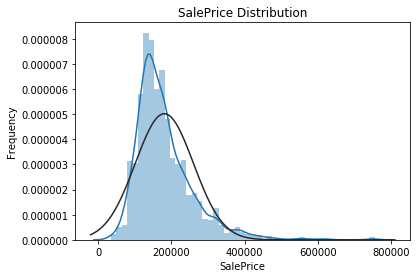

In [8]:
sns.distplot(train_data['SalePrice'], fit=norm)
plt.ylabel('Frequency')
plt.title('SalePrice Distribution')

The SalePrice distribution is right skewed. We have to apply a log transformation to it in order to make it more similar to a normal distribution. We apply the function log(x + 1) using the numpy library.

Text(0.5,1,'SalePrice Distribution')

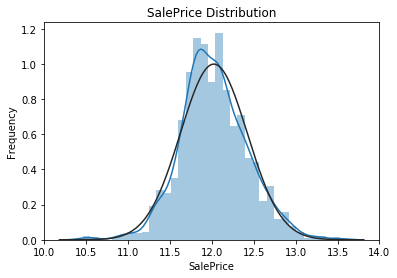

In [9]:
train_data['SalePrice'] = np.log1p(train_data['SalePrice'])
sns.distplot(train_data['SalePrice'], fit=norm)
plt.ylabel('Frequency')
plt.title('SalePrice Distribution')

As result, we get a more normally distributed solution.

## Missing Data

First, let's concatenate the train and test set and process the features with empty cells.

In [10]:
target = train_data['SalePrice']
y_train = target.values
train_data.drop('SalePrice', inplace=True, axis=1)
dim_train = train_data.shape 
dim_test = test_data.shape
data = pd.concat([train_data, test_data])

In [11]:
col_miss_data = (data.isnull().sum()/ len(data)) * 100
col_miss_data.drop(col_miss_data[col_miss_data == 0].index, inplace=True)
col_miss = pd.DataFrame({'missing ratio': col_miss_data})
col_miss['type'] = [data[index].dtypes for index in col_miss.index]

In [12]:
print(col_miss.shape[0], 'columns with missing data')
print('columns with missing data are of type', col_miss['type'].unique())

34 columns with missing data
columns with missing data are of type [dtype('O') dtype('float64')]


### Imputing missing values

We first impute columns of type float.

In [13]:
cont_col_miss = col_miss[col_miss['type'] == 'float'].index.tolist()

In [14]:
col_miss.loc[cont_col_miss,:]

,missing ratio,type
LotFrontage,16.649538,float64
MasVnrArea,0.787941,float64
BsmtFinSF1,0.034258,float64
BsmtFinSF2,0.034258,float64
BsmtUnfSF,0.034258,float64
TotalBsmtSF,0.034258,float64
BsmtFullBath,0.068517,float64
BsmtHalfBath,0.068517,float64
GarageYrBlt,5.447071,float64
GarageCars,0.034258,float64


The features of type float have a low missing ratio.

LotFrontage is the linear feet of street connected to the property. The convinient value to use for filling in missing data is the median of LotFrontage in each Neighborhood

In [15]:
data['LotFrontage'] = data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

The MasVnrArea contains the are of the Masonry veneer is square feet. 

In [16]:
data[data['MasVnrArea'].isnull()]['MasVnrType'].isnull().all()

True

For all the instances where MasVnrArea is empty, MasVnrType is also empty which means the property has no Masonry veneer. So, the most convinient value for the empty cells of MasVnrArea is 0 and None for MasVnrType.

In [17]:
data['MasVnrArea'].fillna(0, inplace=True)
data['MasVnrType'].fillna('None', inplace=True)

For the features BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath and BsmtHalfBath empty cells are more likely to be zeros : no basement.

In [18]:
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    data[col] = data[col].fillna(0)

Missing values in GarageArea, GarageCars are more likely zeros.

In [19]:
data[data['GarageArea'].isnull()]['GarageCars'].isnull().all()

True

In [20]:
for col in ('GarageArea', 'GarageCars'):
    data[col] = data[col].fillna(0)

For GarageYrBlt, it is more convinient to use the median of the years of each Neighborhood

In [21]:
data['GarageYrBlt'] = data.groupby('Neighborhood')['GarageYrBlt'].transform(lambda x: x.fillna(x.median()))

Let's see now the categorical variables

In [22]:
cat_col_miss = col_miss[col_miss['type'] == 'object'].index.tolist()

In [23]:
col_miss.loc[cat_col_miss,:].sort_values('missing ratio', ascending=False)

,missing ratio,type
PoolQC,99.657417,object
MiscFeature,96.402878,object
Alley,93.216855,object
Fence,80.438506,object
FireplaceQu,48.646797,object
GarageQual,5.447071,object
GarageFinish,5.447071,object
GarageCond,5.447071,object
GarageType,5.378554,object
BsmtCond,2.809181,object


Many of the categorical features have a Na category. Though, we will create a list of these features and fill in the missing data with the string None.

In [24]:
feat_na_cat = ['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu',
               'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']
for feat in feat_na_cat:
    data[feat].fillna('None', inplace=True)

In [25]:
remaing_cat_col = [col for col in cat_col_miss if col not in feat_na_cat]

In [26]:
remaing_cat_col

['MSZoning',
 'Utilities',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'Electrical',
 'KitchenQual',
 'Functional',
 'SaleType']

In [27]:
col_miss.loc[remaing_cat_col,:].sort_values('missing ratio', ascending=False)

,missing ratio,type
MasVnrType,0.822199,object
MSZoning,0.137033,object
Utilities,0.068517,object
Functional,0.068517,object
Exterior1st,0.034258,object
Exterior2nd,0.034258,object
Electrical,0.034258,object
KitchenQual,0.034258,object
SaleType,0.034258,object


Above are the remaining categorical features with missing data. Now we are going to fill in empty cells in each  of it sequentially.

Since MSZoning is the zoning classification type, the best value to use for imputing missing data is the mode of MZoning in each Neighborhood.

In [28]:
data['MSZoning'] = data.groupby('Neighborhood')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

For Utilities, the mode value must be a good choice.

In [29]:
data['Utilities'].fillna(data['Utilities'].mode()[0], inplace=True)

Exterior1st and Exterior2nd are the type of the exterior covering of the house. The values we are going to use are the mode of each feature by Neighborhood.

In [30]:
data['Exterior1st'] = data.groupby('Neighborhood')['Exterior1st'].transform(lambda x: x.fillna(x.mode()[0]))
data['Exterior2nd'] = data.groupby('Neighborhood')['Exterior2nd'].transform(lambda x: x.fillna(x.mode()[0]))

For the features KitchenQual, Electrical, SaleType and Functional, We choose to use the mode. 

In [31]:
for col in ('KitchenQual', 'Electrical', 'SaleType', 'Functional'):
    data[col].fillna(data[col].mode()[0], inplace=True)

Let's check if there is still any missing value

In [32]:
col_miss_data = (data.isnull().sum() / len(data)) * 100
col_miss_data.drop(col_miss_data[col_miss_data == 0].index, inplace=True)
col_miss = pd.DataFrame({'missing ratio': col_miss_data})
col_miss

,missing ratio


No remaining empty cells. Now we should explore the possible transformation to apply to the features and do some feature engineering.

## Features engineering

In the data there is three data type. The float features are contineous variables and object features are nominal variables. The data of type integer are ordinal variables or simply integer variables. Let's now explore these type of features and check if using integer type for these features is the best choice for all of them.

In [33]:
int_cat_feat = [col for col in data.columns if data[col].dtype == 'int64']

In [34]:
int_cat_feat

['MSSubClass',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold']

We are going to check these features sequentially : MSSubClass is the type of dwelling involved in the sale, which means that MSSubClass is a variable. So, the type of the feature MSSubClass must be changed to category using astype method of pandas library with the attribut order set to false.

In [35]:
data['MSSubClass'] = data['MSSubClass'].astype(pd.api.types.CategoricalDtype(categories = data['MSSubClass'].unique())) 

LotArea is lot size in square feet. There is no problem in using the integer. OverallQual and OverallCond are ordinal variables. We won't change the type but later we will after use a labelEncoder.

We keep the type integer for YearBuilt, YearRemodAdd, 1stFlrSF, 2ndFlrSF, LowQualFinSF, GrLivArea, FullBath, HalfBath, BedroomAbvGr, KitchenAbvGr, TotRmsAbvGrd, Fireplaces, WoodDeckSF, OpenPorchSF, EnclosedPorch, ScreenPorch, PoolArea, MiscVal, YrSold. However, we will change the type of MoSold to category.

In [36]:
data['MoSold'] = data['MoSold'].astype(pd.api.types.CategoricalDtype(categories = data['MoSold'].unique()))

Before encoding the ordinal variables. Let's before determine the categorical variables that are correlated to the target feature and which we can use in the model. For this, we use the one way ANOVA test. 

In [37]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

train_data_wth_target = train_data
train_data_wth_target['SalePrice'] = target
cat_columns = [col for col in data.columns if data[col].dtypes == 'object']
cat_columns.extend(['MSSubClass', 'MoSold'])
p_val_dic = dict()
for col in cat_columns:
    mod = ols('SalePrice ~' + col, data=train_data_wth_target).fit()
    aov_table = sm.stats.anova_lm(mod, typ=2)
    p_val_dic.update({col: aov_table['PR(>F)'][0]})

C:\Users\Narjes\Anaconda\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [38]:
p_val_df = pd.DataFrame(p_val_dic, index = ['p_val'])
p_val_df = p_val_df.T.sort_values('p_val')

All the features are correlted to SalePrice except for utilities. So, we must drop utilities from the data.

In [39]:
data.drop('Utilities', inplace=True, axis=1)

In [40]:
cont_features = [col for col in data.columns if data[col].dtype == 'float' or data[col].dtype == 'int64']

In [41]:
print('There is', len(cont_features), 'contineous features')

There is 34 contineous features


First let's determine the features correlated to SalePrice.

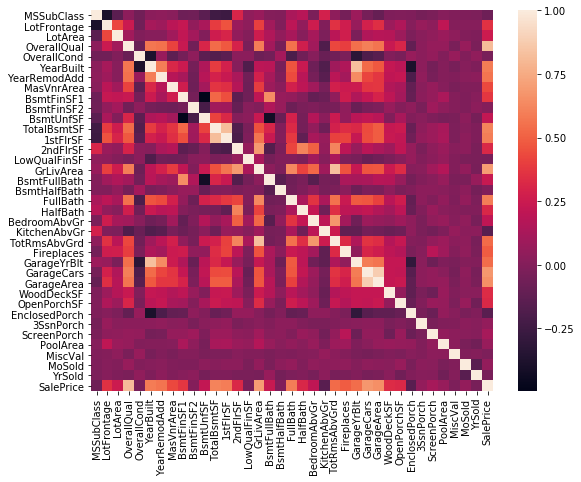

In [42]:
corr_mat = train_data_wth_target.corr()
f, ax = plt.subplots(figsize=(9, 7))
sns.heatmap(corr_mat)

In [43]:
corr_features = [corr_mat.index[i] for coeff, i in zip(corr_mat['SalePrice'], range(len(corr_mat))) 
                 if np.abs(coeff) > 0.5 and np.abs(coeff) < 1]

In [44]:
corr_features

['OverallQual',
 'YearBuilt',
 'YearRemodAdd',
 'TotalBsmtSF',
 '1stFlrSF',
 'GrLivArea',
 'FullBath',
 'TotRmsAbvGrd',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea']

In [45]:
print(len(corr_features), 'features are correlated to SalePrice')

11 features are correlated to SalePrice


For the rest of the features, we try to visualize scatterplots to see if there is any association between the features and SalePrice

In [46]:
remain_cont = [col for col in cont_features if col not in corr_features]

In [47]:
remain_cont

['LotFrontage',
 'LotArea',
 'OverallCond',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'BsmtFullBath',
 'BsmtHalfBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'Fireplaces',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'YrSold']

C:\Users\Narjes\Anaconda\lib\site-packages\matplotlib\pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


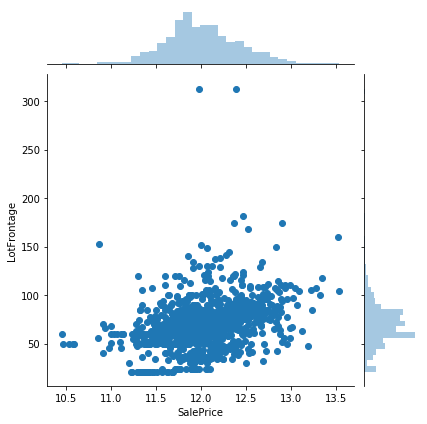

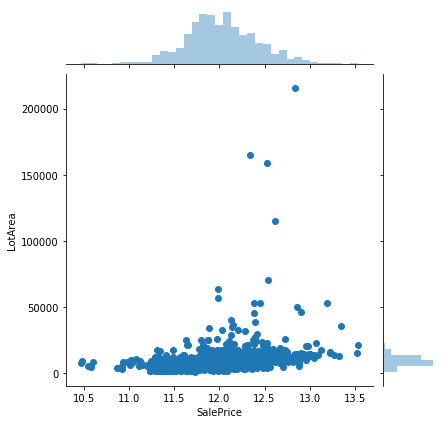

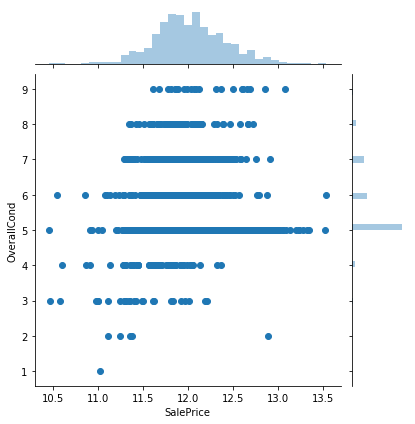

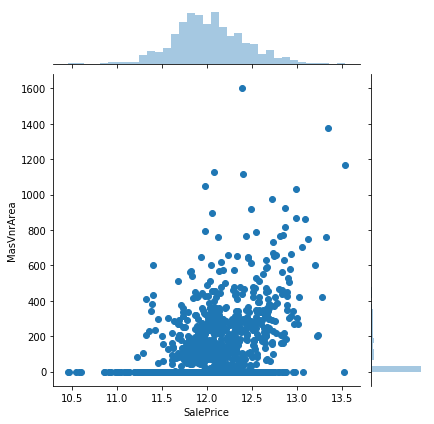

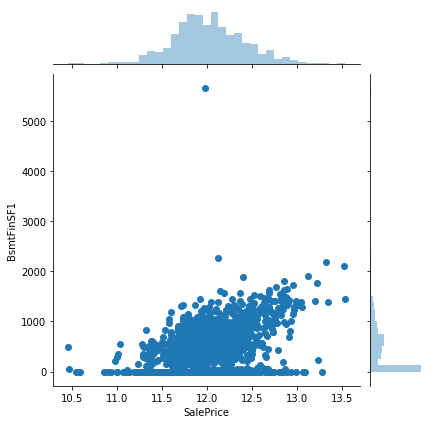

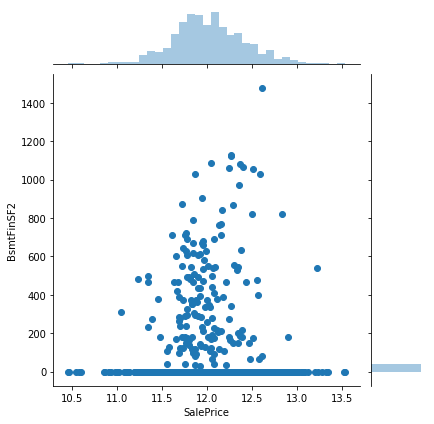

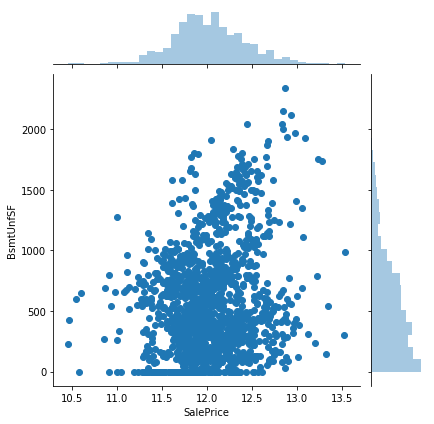

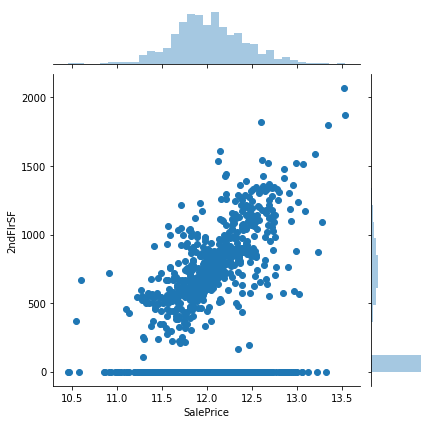

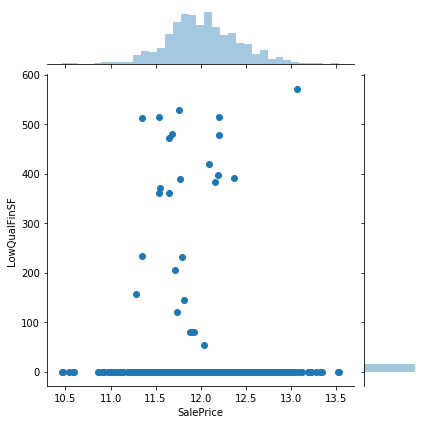

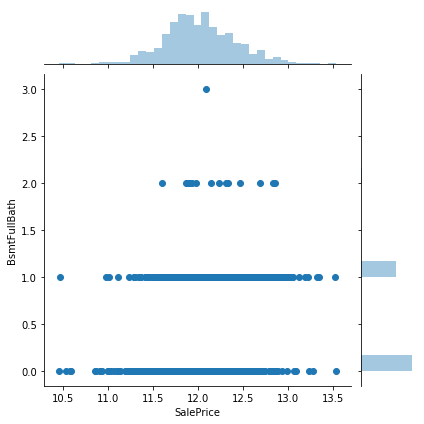

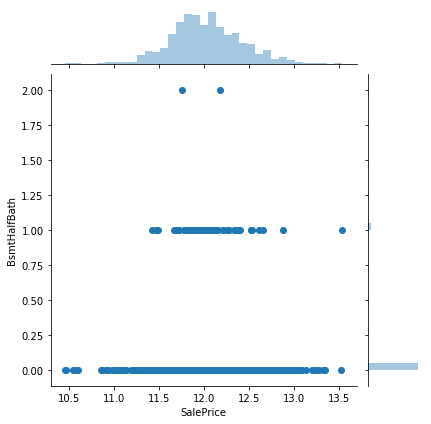

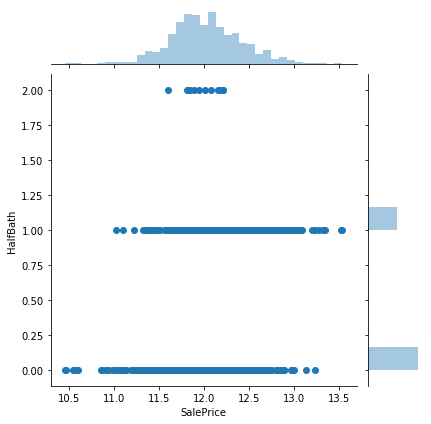

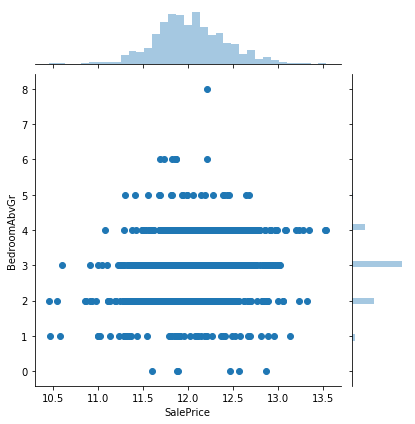

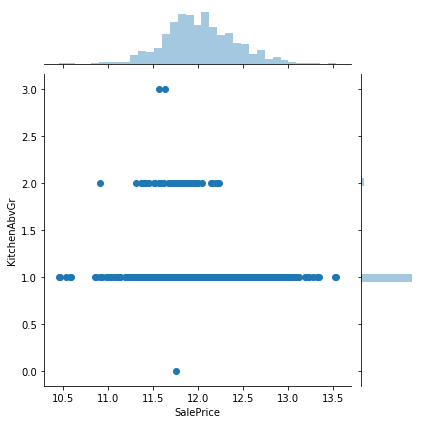

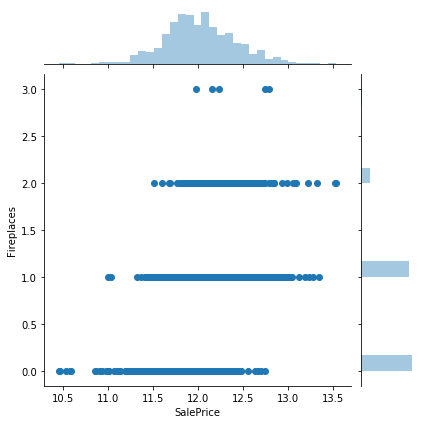

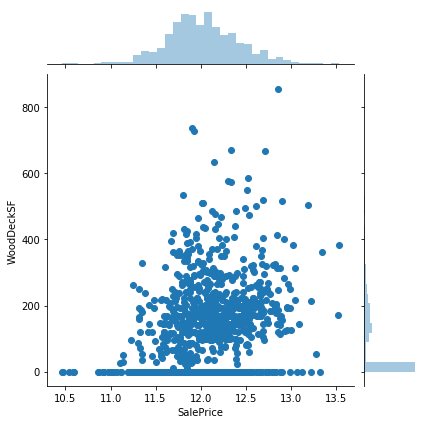

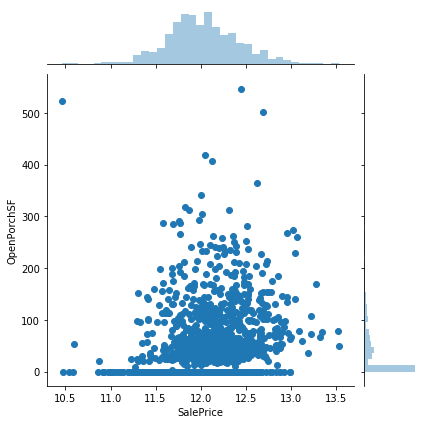

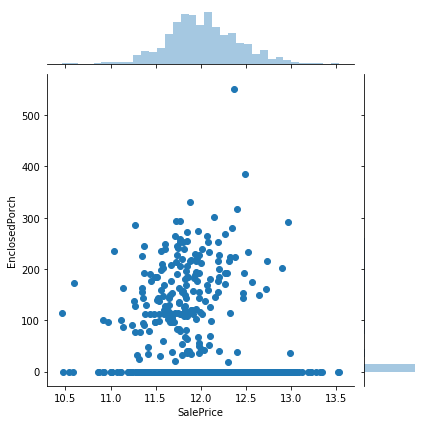

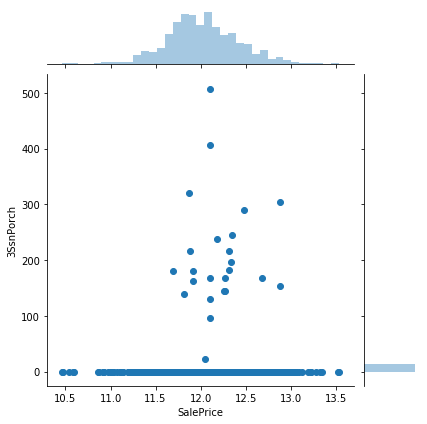

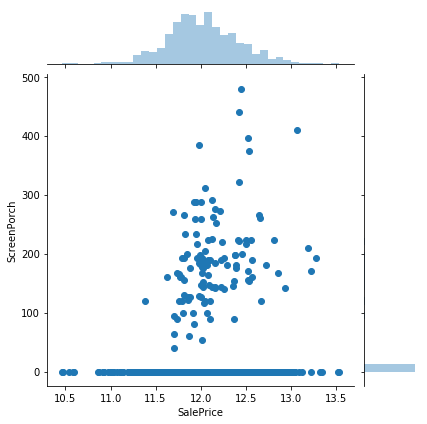

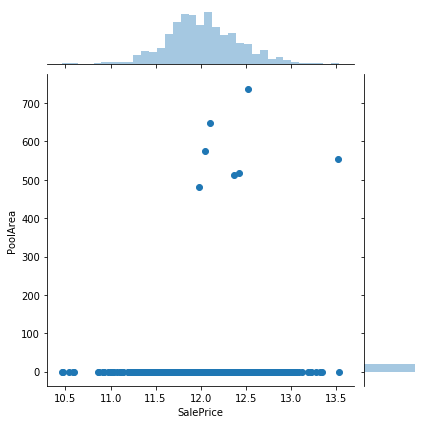

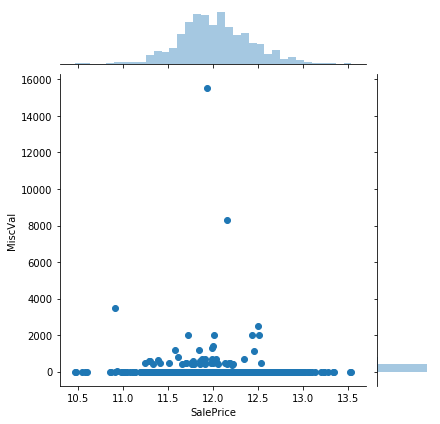

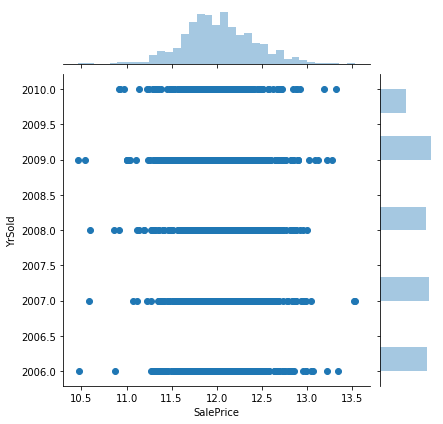

In [48]:
for col in remain_cont:
    sns.jointplot(x='SalePrice', y=col, data=train_data_wth_target);

Based on the above visualization it is possible to consider also features with a correlation coeffecient greater or equal to 0.3 instead 0.5.

In [49]:
corr_features = [corr_mat.index[i] for coeff, i in zip(corr_mat['SalePrice'], range(len(corr_mat))) 
                 if np.abs(coeff) > 0.3 and np.abs(coeff) < 1]

In the model we will use the contineous features in the list corr_features.

#### Label encoding ordinal variables

In [50]:
print(cat_columns)

['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition', 'MSSubClass', 'MoSold']


From the list of categorical variables, we select the ordinal variables and use LabelEncoder.

In [51]:
from sklearn.preprocessing import LabelEncoder
ordinal_feats = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'MoSold')

for col in ordinal_feats:
    lbl = LabelEncoder() 
    lbl.fit(list(data[col].values)) 
    data[col] = lbl.transform(list(data[col].values))

#### Dummies variables

In [52]:
data = pd.get_dummies(data)
print(data.shape)

(2919, 220)


## Modeling

In [53]:
ntrain = train_data.shape[0]
train_data = data[:ntrain]
test_data = data[ntrain:]

Let's start with loading the necessary library

In [54]:
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Lasso, Ridge
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential, clone_model
from keras.layers import Dense
from keras import regularizers
import xgboost as xgb

C:\Users\Narjes\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [55]:
def rse(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

X = train_data.values
y = y_train
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.33, random_state=42)

In [56]:
rf_regressor = RandomForestRegressor(n_estimators=3000, max_features='sqrt')

In [57]:
rf_regressor.fit(train_X, train_y)
y_pred = rf_regressor.predict(test_X)
score = rse(y_pred, test_y)
print('Random Forest score', score)

Random Forest score 0.1502610869580205


In [58]:
gb_regressor = GradientBoostingRegressor(n_estimators=3100, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

In [59]:
gb_regressor.fit(train_X, train_y)
y_pred = gb_regressor.predict(test_X)
score = rse(y_pred, test_y)
print('Gadient Boosting score', score)

Gadient Boosting score 0.1305782802623527


In [60]:
xgb_regressor = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state=7, nthread = -1)

In [61]:
xgb_regressor.fit(train_X, train_y)
y_pred = xgb_regressor.predict(test_X)
score = rse(y_pred, test_y)
print('Extended Gadient Boosting score', score)

Extended Gadient Boosting score 0.13115338685488326


In [62]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha=0.0001, random_state=1))

In [63]:
ridge = make_pipeline(RobustScaler(), Ridge(alpha=0.0001, random_state=1))

In [64]:
lasso.fit(train_X, train_y)
y_pred = lasso.predict(test_X)
score = rse(y_pred, test_y)
print('Lasso score', score)

Lasso score 0.1228679610848678


In [65]:
ridge.fit(train_X, train_y)
y_pred = ridge.predict(test_X)
score = rse(y_pred, test_y)
print('Ridge score', score)

Ridge score 0.1307665033231361


In [66]:
## input must be normalized
scaler_x = MinMaxScaler(feature_range=(0,1))
scaler_x = scaler_x.fit(X)
train_X_n = scaler_x.transform(train_X)
test_X_n = scaler_x.transform(test_X)

keras_regressor = Sequential()
keras_regressor.add(Dense(40, input_dim=X.shape[1], kernel_initializer='normal', activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
keras_regressor.add(Dense(20, kernel_initializer='normal', activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
keras_regressor.add(Dense(1, kernel_initializer='normal'))
keras_regressor.compile(loss='mean_squared_error', optimizer='adam')
history = keras_regressor.fit(train_X_n, train_y, epochs=100, batch_size=50, validation_data=(test_X_n, test_y))
y_pred = keras_regressor.predict(test_X_n)
score = rse(y_pred, test_y)
print('Keras regressot score', score)

Train on 978 samples, validate on 482 samples
Epoch 1/100
978/978 [==============================] - 1s 1ms/step - loss: 143.2114 - val_loss: 139.4728
Epoch 2/100
978/978 [==============================] - 0s 189us/step - loss: 130.9122 - val_loss: 114.3195
Epoch 3/100
978/978 [==============================] - 0s 194us/step - loss: 86.8186 - val_loss: 47.4933
Epoch 4/100
978/978 [==============================] - 0s 182us/step - loss: 18.0957 - val_loss: 0.2498
Epoch 5/100
978/978 [==============================] - 0s 150us/step - loss: 1.3616 - val_loss: 0.4693
Epoch 6/100
978/978 [==============================] - 0s 158us/step - loss: 0.3113 - val_loss: 0.2870
Epoch 7/100
978/978 [==============================] - 0s 134us/step - loss: 0.2151 - val_loss: 0.2213
Epoch 8/100
978/978 [==============================] - 0s 126us/step - loss: 0.1987 - val_loss: 0.1963
Epoch 9/100
978/978 [==============================] - 0s 118us/step - loss: 0.1859 - val_loss: 0.1885
Epoch 10/100
978/9

Epoch 80/100
978/978 [==============================] - 0s 48us/step - loss: 0.0228 - val_loss: 0.0430
Epoch 81/100
978/978 [==============================] - 0s 51us/step - loss: 0.0224 - val_loss: 0.0423
Epoch 82/100
978/978 [==============================] - 0s 60us/step - loss: 0.0221 - val_loss: 0.0427
Epoch 83/100
978/978 [==============================] - 0s 59us/step - loss: 0.0216 - val_loss: 0.0418
Epoch 84/100
978/978 [==============================] - 0s 56us/step - loss: 0.0218 - val_loss: 0.0417
Epoch 85/100
978/978 [==============================] - 0s 53us/step - loss: 0.0216 - val_loss: 0.0414
Epoch 86/100
978/978 [==============================] - 0s 55us/step - loss: 0.0214 - val_loss: 0.0415
Epoch 87/100
978/978 [==============================] - 0s 53us/step - loss: 0.0210 - val_loss: 0.0406
Epoch 88/100
978/978 [==============================] - 0s 50us/step - loss: 0.0206 - val_loss: 0.0401
Epoch 89/100
978/978 [==============================] - 0s 51us/step - lo

In [67]:
class neural_regressor:
    def __init__(self, model, epochs, batch_size):
        self.epochs = epochs
        self.batch_size = batch_size
        self.model = clone_model(model)
        
    def fit(self, X, y):
        self.model.compile(loss='mean_squared_error', optimizer='adam')
        self.model.fit(X, y, epochs=50, batch_size=50, verbose=0)
        return self
        
    def predict(self, X):
        y_pred = self.model.predict(X)
        return y_pred

### Stacking

In the stacking model, we are going to use Random Forest, Gradient Boosting and Feed Forward Neural Network as sub models and lasso as an aggregator model.

In [68]:
class StackingModel:
    def __init__(self, base_models, neural_models, meta_model):
        self.base_models = base_models
        self.meta_model = meta_model
        self.neural_models = neural_models
        
    def base_models_predictions(self, train_X, train_y, test_X):
        predictions = np.zeros((test_X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
                instance = clone(model)
                self.base_models_.append(instance)
                instance.fit(train_X, train_y)
                y_pred = instance.predict(test_X)
                predictions[:, i] = y_pred
        return predictions
    
    def neural_models_predictions(self, train_X, train_y, test_X):
        predictions = np.zeros((test_X.shape[0], len(self.neural_models)))
        for i, (model, epochs, batch_size) in enumerate(self.neural_models):
            instance = neural_regressor(model, epochs, batch_size)
            self.neural_models_.append(instance)
            instance.fit(train_X, train_y)
            y_pred = instance.predict(test_X)
            predictions[:, i] = y_pred.reshape(y_pred.shape[0]) 
        return predictions
    
    def fit(self, X, y):
        self.base_models_ = list()
        self.neural_models_ = list()
        self.meta_model_ = clone(self.meta_model)
        train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.33, random_state=42)
        base_predictions = self.base_models_predictions(train_X, train_y, test_X)
        neural_predictions = self.neural_models_predictions(train_X, train_y, test_X)
        predictions = np.concatenate((base_predictions, neural_predictions), axis=1)
        self.meta_model_.fit(predictions, test_y)
        return self
    
    def predict(self, X):
        base_features = np.column_stack([model.predict(X) for model in self.base_models_])
        neural_features = np.column_stack([model.predict(X) for model in self.neural_models_])
        meta_features = np.concatenate((base_features, neural_features), axis=1)
        return self.meta_model_.predict(meta_features)

In [69]:
stacked_models = StackingModel(base_models=[rf_regressor, gb_regressor, xgb_regressor], 
                               neural_models=[(keras_regressor, 50, 50)], meta_model=lasso)
stacked_models.fit(X, y)
y_pred = stacked_models.predict(X)
score = rse(y, y_pred)

In [71]:
print(score)

0.08632644217521897


In [72]:
test_data = data[ntrain:]
test_X = test_data.values
y_pred = stacked_models.predict(test_X)
y_sub = np.expm1(y_pred)
data_sub = pd.DataFrame()
data_sub['Id'] = test_id
data_sub['SalePrice'] = y_sub

In [73]:
data_sub.to_csv('submission.csv', index=False)